## R-CNN 

There are 4 steps in R-CNN. They are as follows:

1) The first module generates category-independent region proposals (Image to RoI).
    - Pass the image through `selective search`/any other method and generate region proposal. Given an input image, around 2000 bottom-up region proposals are extracted.
    - Calculate `IOU (intersection over union)` on proposed region with ground truth data and add label to the proposed regions
    - Do `transfer learning` using the proposed regions with the labels.
2) The second module is a large convolutional neural network that extracts a `fixed-length feature vector` from each region (RoI to `VGG/AlexNet/ResNets` to Features).
    - We use VGG 16 trained on ImageNet.
3) The third module is a `set of classs-specific linear SVMs` (Using this feature vector to train a SVM).
    - Classification of each region using class-specific linear SVMs (or MLPs).
4) Predict Bounding Box using `Ridge Regression` (Use bounding box regression for more accurate results)
    - Non-max Suppression

Note:
- Hyperparameters were not tunned properly because the work is focused on the implementation of the R-CNN model.

In [2]:
import os
os.chdir('../')
os.chdir('../')
%pwd

'd:\\work\\.ghorai\\Repository\\in-progress\\object-detection'

##### R-CNN Implementation:
The R-CNN object detection system consists of three modules. The first generates category-independent region proposals(through selective search here). These propositions define the candidate detections available to our detector. The second module is a large convolutional neural network that extracts a fixed-length feature vector from each region (here we use VGG 16, while the original paper runs on AlexNet). The third module is a set of class-specific linear SVMs. So let's introduce them step by step.

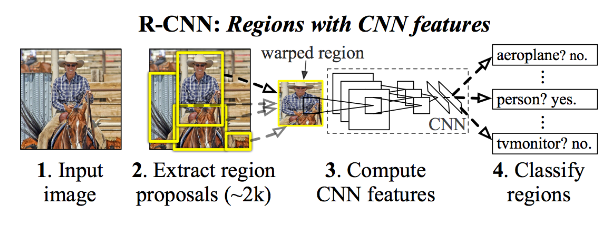

## Steps to follow:
- Build an object detection (OD) dataset using `Selective Search` algorithm
- Fine-tune a classification network for feature extraction from region proposals
- Find 4096 image/feature from pretrained Alexnet/VGG16 model for each image (for training and validation set)
- Learning an individual linear SVM classifier for each class, that detects the presence or absence of an object belonging to a particular class
- In order to improve localization performance, a bounding-box regression step to learn corrections in the predicted bounding box location and size is applied
- Create an OD inference script with selective search functionality to propose regions that could contain an object that we would like to detect
- Apply non-maximum suppression (NMS) to suppress weak, overlapping bounding boxex
- Return the final OD results 


#### Selective Search Algorithm
Selective Search is a region proposal algorithm used in object detection. It is designed to be fast with a very high recall. It is based on computing hierarchical grouping of similar regions based on color, texture, size and shape compatibility.

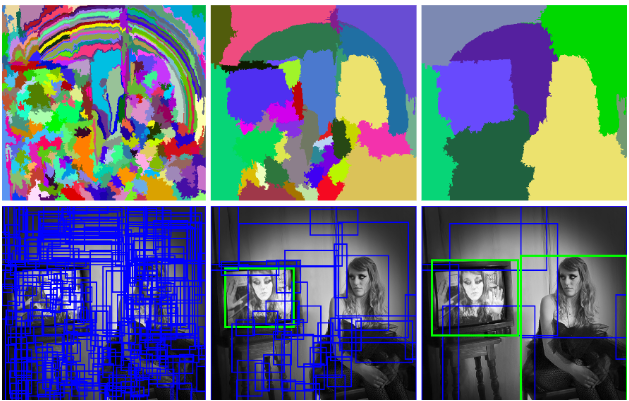

- Each of the bounding box is calculated IOU with the ground truth.
- If we have more than one object present in an image, then each generated bounding boxes will compare IOU with every each of object ground-truth bounding box.
- If IOU is greater than 70% (or 0.7), we will select this generated bounding box with corresponding label assigned by ground-truth bounding box.
- If IOU is less than 30% (or 0.3), we will select this generated bounding box with corresponding label as ‘background’
- We need to create an extra class label called background because we don’t want to detect every object present in surrounding like road, cloud, grass, etc. These are not so importance to detect the object but model need to know and learn about what background images are.
- Now, while you are selecting from generated Bounding Box based on IOU score, then: (i) Crop the image within selected generated Bounding Box and (ii) Resize the cropped image into 227x227 (Because generated bounding box are not in equal shape, so we need to bring all the cropped image into one fixed input size or shape).
- We are saving 4 things: (i) list of cropped (or ROI) images — (10838 subset img, 227 height, 227 width, 3 channel), (ii) their corresponding labels — (10838,1), (iii) selected proposal (using Selective Search Algorithm) bounding box P — (10838, 4 -> xmin, ymin, xmax, ymax), and (iv) ground-truth bounding box G — (10838, 4 -> xmin, ymin, xmax, ymax).
- These P and G will be useful when we are dealing in Bounding Box Regression.

In [2]:
import pandas as pd

img_dir = "research/data/data_split/train"
annotation = "research/data/data_split/train/train_labels.csv"

annot = pd.read_csv(annotation)
annot

,filename,width,height,class,xmin,ymin,xmax,ymax
0,Abyssinian_10.jpg,375,500,cat,72,105,288,291
1,Abyssinian_101.jpg,450,313,cat,54,36,319,235
2,Abyssinian_102.jpg,500,465,cat,23,27,325,320
3,Abyssinian_103.jpg,500,351,cat,241,68,362,196
4,Abyssinian_105.jpg,500,375,cat,237,101,373,227
...,...,...,...,...,...,...,...,...
2649,yorkshire_terrier_182.jpg,500,375,dog,101,68,271,189
2650,yorkshire_terrier_183.jpg,375,500,dog,42,116,226,241
2651,yorkshire_terrier_186.jpg,500,375,dog,208,32,356,231
2652,yorkshire_terrier_187.jpg,500,334,dog,187,49,317,181


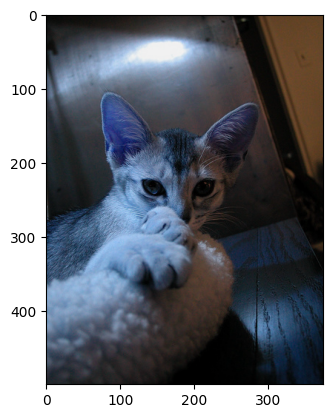

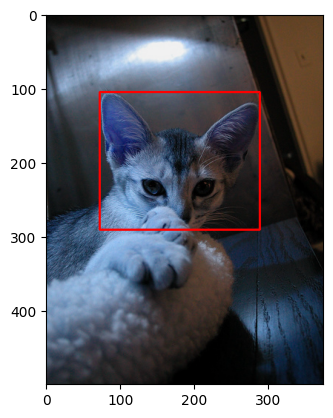

<Figure size 640x480 with 0 Axes>

In [3]:
import cv2
import matplotlib.pyplot as plt

# plot
for ix, row in annot.iterrows():
    if ix < 10:
        file_name = row['filename']
        img = cv2.imread(os.path.join(img_dir, file_name))
        x1 = row['xmin']
        y1 = row['ymin']
        x2 = row['xmax']
        y2 = row['ymax']
        plt.imshow(img)
        plt.figure()
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        text = "Cat: {:.2f}%".format(98.5)
        y = y1 - 10 if y1 - 10 > 10 else y1 + 10
        cv2.putText(img.copy(), text, (x1, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
        plt.imshow(img)
        # cv2.imshow("Cat", img.copy())
        # k = cv2.waitKey(0)
        # cv2.destroyAllWindows()
        plt.figure()
        break

In [6]:
# stage-1: Region proposals: 
# (i) selective search algorithm (generating sub-segmentations of the image that could belong to one object 
# — based on color, texture, size and shape - and iteratively combining similar regions to form objects), (ii) The authors use the selective search algorithm to generate 2000 category 
# independent region proposals for each individual image.

# reference: https://learnopencv.com/selective-search-for-object-detection-cpp-python/

# import sys
import cv2
# import numpy as np

# speed-up using multithreads
cv2.setUseOptimized(True)
cv2.setNumThreads(4)


def cv2_selective_search(img_arr, ss_type='fast'):
    # create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # set input image on which we will run segmentation
    ss.setBaseImage(img_arr)

    # there are two ways to perform selective serch
    if ss_type == 'fast':
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()

    # run selective search segmentation on input image
    ss_results = ss.process()

    return ss_results

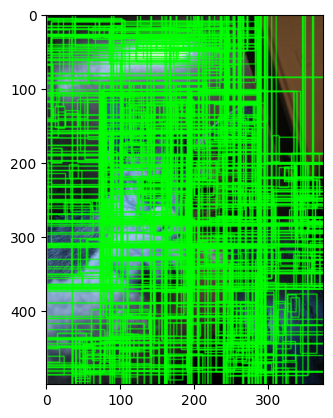

In [5]:
im = cv2.imread(os.path.join(img_dir,"Abyssinian_10.jpg"))

rects = cv2_selective_search(im)

imOut = im.copy()

for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
plt.imshow(imOut)

#### IOU

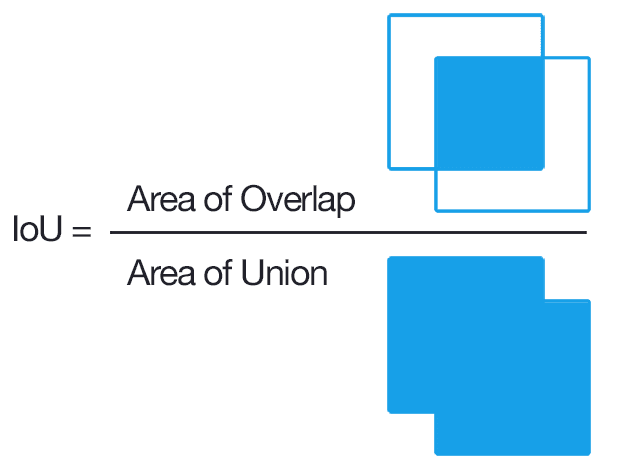

In [6]:
# Please access this page to understand IoU more deeply: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

def get_iou(bb1, bb2):
    '''
    Calculate IOU of two bounding box

    Parameters:
    bb1: First bounding box in dict() format which contain 4 coordinates with labelled as 'x1','y1','x2','y2'
    bb2: Second bounding box in dict() format which contain 4 coordinates with labelled as 'x1','y1','x2','y2'

    Return:
    IOU value

    Reference:
    https://github.com/sahilsharma884/RCNN_Scratch/blob/master/R-CNN.ipynb
    https://github.com/lattice-ai/RCNN/blob/master/notebooks/RCNN.ipynb
    https://ammarchalifah.wordpress.com/2020/09/13/rcnn-implementation-with-tensorflow-2-3-and-its-application-in-video-processing/
    

    '''

    # Make sure in both Bounding boxes coordinates are valid
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # Finding intersection
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    # Checking whether there is any intersection avaiable
    # If not, return area of intersection as 0.
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # Otheriwise
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # To bring into percentage, calculate area of each bounding box
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # p(AUB) = p(A) + p(B) - p(A,B)
    total_area = float(bb1_area + bb2_area - intersection_area)

    # Finally in percentage
    iou = intersection_area / total_area

    # Make sure, IOU values within 0 to 1
    assert iou >= 0.0
    assert iou <= 1.0

    return iou


#### Preparing training data 

[Training data here is prepared according to following scheme](https://github.com/Hulkido/RCNN/blob/master/RCNN.ipynb):
- Those boxes which have an IoU greater than 0.7 (original paper it's 0.5) are considered as a positive example.
- And boxes with relative low IoU 0.3 are taken to be negative examples.
- Number of regions taken here is 30 positive and 30 negative (original paper have 32 and 96 respectively) of size 224x224. 

Note: Original paper also talk about warping but as we have resized them already so there is no need of it.

In [7]:
# prepare training data

def get_sample_data(img_dir, annot, n_sample=30, region_size=(224, 224)):
    train_images = []
    train_labels = []
    region_proposal = []
    ground_boundary = []
    labels = []

    for ix, row in annot.iterrows():
        try:
            file_name = row['filename']
            label_name = row['class']
            img = cv2.imread(os.path.join(img_dir, file_name))
            gtvalues = [
                {
                    "x1": row['xmin'],
                    "y1": row['ymin'],
                    "x2": row['xmax'],
                    "y2": row['ymax']
                }
            ]
            # ss.setBaseImage(img)
            # ss.switchToSelectiveSearchFast()
            ssresults = cv2_selective_search(img)
            imout = img.copy()

            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0

            for e, result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for g_coords in gtvalues:
                        x, y, w, h = result
                        rp_coords = {"x1": x, "y1": y, "x2": x+w, "y2": y+h}
                        iou = get_iou(g_coords, rp_coords)
                        # we will collect maximum of 5 positive sample (i.e. cat/dog) and 5 negative sample (i.e. background) from one image out off 2000 selective search regions/box.
                        if counter < n_sample:
                            if iou > 0.70: # foreground/positive class
                                timage = imout[y:y+h, x:x+w]
                                # image size used as per original RCNN paper
                                resized = cv2.resize(
                                    timage, region_size, interpolation=cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                region_proposal.append([rp_coords['x1'], rp_coords['y1'], rp_coords['x2'], rp_coords['y2']])
                                ground_boundary.append([g_coords['x1'], g_coords['y1'], g_coords['x2'], g_coords['y2']])
                                labels.append(label_name)
                                counter += 1
                        else:
                            fflag = 1

                        # collect negative/background samples
                        if falsecounter < n_sample:
                            if iou < 0.3: # background/negative class
                                timage = imout[y:y+h, x:x+w]
                                # image size used as per original RCNN paper
                                resized = cv2.resize(
                                    timage, region_size, interpolation=cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                region_proposal.append([0, 0, 0, 0])
                                ground_boundary.append([0, 0, 0, 0])
                                labels.append('background')
                                falsecounter += 1
                        else:
                            bflag = 1

                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
        except Exception as e:
            print(e)
            print(f"error in {file_name}")
            continue

    return train_images, train_labels, region_proposal, ground_boundary, labels

In [8]:
train_images, train_labels, region_proposal, ground_boundary, labels = get_sample_data(
    img_dir, annot, n_sample=30, region_size=(224, 224)
)


inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside


In [9]:
# save data
import pickle
import tensorflow as tf
import numpy as np

from sklearn.preprocessing import LabelBinarizer


ENCODER_PATH = "artifacts/label_encoder.pickle"

lb = LabelBinarizer()

# labels = ['dog' for _ in range(8)] + ['cat' for _ in range(7)]
labels = lb.fit_transform(labels)
labels = tf.keras.utils.to_categorical(labels)

# save
f = open(ENCODER_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()


X_new = np.array(train_images)
y_new = np.array(train_labels)

rp_coords = np.array(region_proposal)
gb_coords = np.array(ground_boundary)

# save
np.save(os.path.join('artifacts/training_data', 'train_x_224.npy'), X_new)
np.save(os.path.join('artifacts/training_data', 'train_y_224.npy'), y_new)

np.save(os.path.join('artifacts/training_data', 'rp_coords_224.npy'), rp_coords)
np.save(os.path.join('artifacts/training_data', 'gb_coords_224.npy'), gb_coords)


In [10]:
def load_npy_data(data_dir=None, npy_file=None):
    npy_file_path = os.path.join(data_dir, npy_file)
    npy_data = np.load(npy_file_path)
    return npy_data

[Pre-training](https://github.com/Hulkido/RCNN/blob/master/RCNN.ipynb)

stage-2: Feature extraction from Region Proposals:
- the authors generate a 4096 dimensional feature vector from each of the 2000 region proposals for every image using a Convolutional Neural Network (CNN)
- Training process: 
    - Supervised Pre-training on  “AlexNet” model that has 5 convolutional and 2 fully connected layers
    - Domain-Specific Fine-Tuning - fine-tune the classification network to identify the classes belonging to the detection task from the region proposals.
- After training, the final classification layer is removed and a 4096 dimensional feature vector is obtained from the penultimate layer of the CNN for each of the 2000 region proposals for every image. 

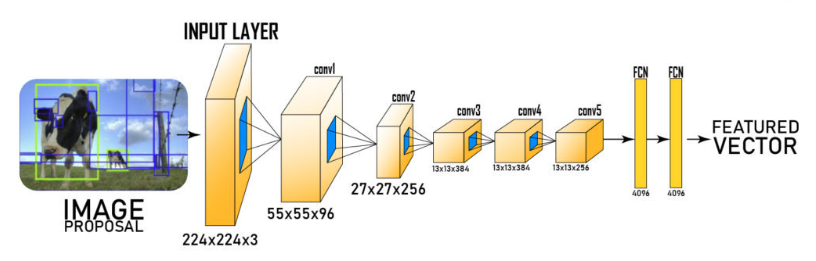

Image source: https://www.geeksforgeeks.org/r-cnn-region-based-cnns/?ref=ml_lbp


In order to successfully classify our custom images, we need to remove the final, 1000-neuron classification layer and replace it with a new, n-neuron classification layer (2-classes for this example).

VGG16:


1. We will use VGG16 as our feature extractor. Download the pretrained model using Keras API. 
2. The model is already trained on ImageNet dataset, so it is already pretty good at extracting features from various classes.

In [11]:
n_classes = 2

vgg16model = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet')
# vgg16model.summary()

for layers in (vgg16model.layers)[:-2]:
    print(layers)
    layers.trainable = False

# remove last output layer from the model
X = vgg16model.layers[-2].output  # x = vgg16model.get_layer('fc2')
output_layer = tf.keras.layers.Dense(n_classes, activation="softmax")(X)

new_model = tf.keras.Model(vgg16model.input, output_layer)
# new_model.summary()

new_model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

new_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
# read data
import numpy as np

# if data already not loaded

# X_new = load_npy_data(data_dir='artifacts/training_data', npy_file='train_x_224.npy')

# y_new = load_npy_data(data_dir='artifacts/training_data', npy_file='train_y_224.npy')


In [23]:
# reduce the sample size due to memory issue in the local system
X_new_sample = X_new[0:100, :,:,:]
y_new_sample = y_new[0:100,]

In [24]:
from sklearn.model_selection import train_test_split

# enable run function eagerly as you attempt to utilize the function decorator in TF 2.0
tf.config.run_functions_eagerly(True)
# To force eager execution of tf.data functions
tf.data.experimental.enable_debug_mode()

# X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_new, y_new, test_size=0.50)
X_train, X_valid, y_train, y_valid = train_test_split(X_new_sample, y_new_sample, test_size=0.20)

# convert y_train and y_valid to one-hot-encoding (multi-class classification)
y_train_cat = tf.keras.utils.to_categorical(y_train, n_classes)
y_valid_cat = tf.keras.utils.to_categorical(y_valid, n_classes)


callback = [
    tf.keras.callbacks.ModelCheckpoint("artifacts/best_model/vgg_model_v2.h5", save_weights_only=False, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    ]


new_model.fit(
    X_train, 
    y_train_cat, 
    batch_size=16, 
    epochs=2, 
    validation_data=(X_valid, y_valid_cat), 
    shuffle=True, 
    callbacks=callback, 
    verbose=1
    )

Epoch 1/2
5/5 [==============================] - 458s 102s/step - loss: 0.7570 - accuracy: 0.9000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/2
5/5 [==============================] - 537s 108s/step - loss: 3.4273e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [27]:
import tqdm # To Display the progress bar
import tensorflow as tf
import numpy as np

# https://github.com/sahilsharma884/RCNN_Scratch/blob/master/R-CNN.ipynb
# Load Architecture and weights

custom_model = tf.keras.models.load_model('artifacts/best_model/vgg_model_v2.h5')

# json_file = open('alexnet_arch.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# loaded_model.load_weights("alexnet_weights.hdf5")

# Create another instantiate for removing last layer.
model = tf.keras.models.Model(custom_model.input, custom_model.layers[-2].output)
model.summary()

# Load Train images performed ROI using SelectiveSearchAlgorithm
# train_X = np.load(os.path.join('artifacts/training_data', 'train_x_224.npy'))
train_X = X_new_sample

print(train_X.shape)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [28]:
# Find 4096 image/feature from pretrained Alexnet/VGG16 for each image
train_feat = []
for i in tqdm.tqdm_notebook(range(train_X.shape[0])):
    train_feat.append(list(model.predict(np.expand_dims(train_X[i], axis=0))[0]))

C:\Users\USER\AppData\Local\Temp\ipykernel_6016\1325122356.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(train_X.shape[0])):


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


In [29]:
# Store the profress of 4096 feature extracted image
train_feat = np.array(train_feat)
np.save(os.path.join('artifacts/training_data', 'train_X_feat.npy'), train_feat)

In [30]:
# Display some top value
print(train_feat[:10])

[[0.8870392  2.0893292  0.46182194 ... 0.17910975 0.         0.3690475 ]
 [0.         2.087613   0.29702812 ... 0.257939   0.         0.14465225]
 [0.7797849  1.9196339  0.92697525 ... 0.         0.         0.4037731 ]
 ...
 [1.35124    1.3465656  0.6827144  ... 0.06693059 0.         0.22884363]
 [0.2875685  1.6984743  0.6706924  ... 0.35264856 0.         0.        ]
 [1.0642881  1.078124   0.6751159  ... 0.95696753 0.         0.25152463]]


In [31]:
# Similarily perform for val data
val_img_dir = 'research/data/data_split/valid'
val_annot = pd.read_csv("research/data/data_split/valid/valid_labels.csv")

val_images, val_labels, val_region_proposal, val_ground_boundary, val_labels = get_sample_data(val_img_dir, val_annot, n_sample=2, region_size=(224, 224))

inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside
inside

In [32]:
val_X = np.array(val_images)
val_y = np.array(val_labels)
rp_coords_val = np.array(val_region_proposal)
gb_coords_val = np.array(val_ground_boundary)

# save
np.save(os.path.join('artifacts/training_data', 'val_x_224.npy'), val_X)
np.save(os.path.join('artifacts/training_data', 'val_y_224.npy'), val_y)

np.save(os.path.join('artifacts/training_data', 'val_rp_coords_224.npy'), rp_coords_val)
np.save(os.path.join('artifacts/training_data', 'val_gb_coords_224.npy'), gb_coords_val)

In [33]:
val_feat = []
for i in tqdm.tqdm_notebook(range(val_X.shape[0])):
    val_feat.append(list(model.predict(np.expand_dims(val_X[i], axis=0))[0]))

# Store the profress of 4096 feature extracted image
val_feat = np.array(val_feat)
np.save(os.path.join('artifacts/training_data', 'val_X_feat.npy'), val_feat)

C:\Users\USER\AppData\Local\Temp\ipykernel_6016\1799288371.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(val_X.shape[0])):


  0%|          | 0/1071 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


In [36]:
# stage-3: SVM for object classification
# this stage consists of learning an individual linear SVM classifier for each class, that detects the presence or absence of an object belonging to a particular class.
# Labels for training - considered positive regions: IoU > 0.7 and negative regions: IoU < 0.3 from all the region proposal of every image
# After training the SVM, the final output is a set of positive object proposals for each class, from the CNN features of 2000 region proposals of every image.

from sklearn.svm import SVC # For classifying object
import numpy as np # To load the .npy file

# Load images from both train and val
train_X = np.load('artifacts/training_data/train_X_feat.npy')
val_X = np.load('artifacts/training_data/val_X_feat.npy')

# Load label from both train and val
train_y = np.load('artifacts/training_data/train_y_224.npy')
train_y = train_y[0:100,]
val_y = np.load('artifacts/training_data/val_y_224.npy')

# Hyperparameter value for SVM
params = {'C':[10**i for i in range(-4,5)], 'gamma': ['scale','auto']}
params


{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
 'gamma': ['scale', 'auto']}

In [37]:
# Store the best_param you have got
best_param = dict()

# Exactly like a GridSearch If you know.
# Iterative process over every value present in params to find best parameter possible

for c in params['C']:
    val_maxscore = 0

    for g in params['gamma']:
        # Instantiate the SVM model
        svm_clf = SVC(random_state=1, kernel='linear', C=c, gamma=g, probability=True)
        # Fit the train data
        svm_clf.fit(train_X,train_y)
        # Find the score on both train and val
        tr_score = svm_clf.score(train_X, train_y)
        val_score = svm_clf.score(val_X,val_y)

        # Update the score and params which give best parameter value.
        if val_maxscore < val_score:
            val_maxscore = val_score
            best_param['C']=c
            best_param['gamma']=g
            
        print('C={}, gamma={}: train score={}, cv score={}'.format(c, g, tr_score, val_score))

d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


C=0.0001, gamma=scale: train score=1.0, cv score=0.0
C=0.0001, gamma=auto: train score=1.0, cv score=0.0
C=0.001, gamma=scale: train score=1.0, cv score=0.0
C=0.001, gamma=auto: train score=1.0, cv score=0.0


d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


C=0.01, gamma=scale: train score=1.0, cv score=0.0
C=0.01, gamma=auto: train score=1.0, cv score=0.0
C=0.1, gamma=scale: train score=1.0, cv score=0.0
C=0.1, gamma=auto: train score=1.0, cv score=0.0


d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


C=1, gamma=scale: train score=1.0, cv score=0.0
C=1, gamma=auto: train score=1.0, cv score=0.0
C=10, gamma=scale: train score=1.0, cv score=0.0
C=10, gamma=auto: train score=1.0, cv score=0.0


d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


C=100, gamma=scale: train score=1.0, cv score=0.0
C=100, gamma=auto: train score=1.0, cv score=0.0
C=1000, gamma=scale: train score=1.0, cv score=0.0
C=1000, gamma=auto: train score=1.0, cv score=0.0
C=10000, gamma=scale: train score=1.0, cv score=0.0
C=10000, gamma=auto: train score=1.0, cv score=0.0


d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred
d:\mlenv\lib\site-packages\sklearn\metrics\_classification.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  score = y_true == y_pred


In [38]:
svm_clf = SVC(random_state=1, kernel='linear', C=0.01, gamma='auto', probability=True)

svm_clf.fit(train_X, train_y)

SVC(C=0.01, gamma='auto', kernel='linear', probability=True, random_state=1)

In [39]:
train_X.shape
train_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
# Save the model
from joblib import dump

dump(svm_clf, 'artifacts/best_model/svm_classify_object.pkl')

['artifacts/best_model/svm_classify_object.pkl']

In [41]:
# stage-4: Bounding box regression
# In order to improve localization performance, the authors include a bounding-box regression step to learn corrections in the predicted bounding box location and size.
# For all the positive region proposals of each class predicted from the SVM, we have an accurate, corrected bounding box around the object.

import numpy as np # To load `P` and `G` BB value.

# Exactly formulated as given above image
def target_bounding_box(region_proposal, ground_annotation):
    '''
    Return target value `t` and also update P and G with coordinate [x,y,w,h] instead of [x1,y1,x2,y2]
    
    Parameters:
    P: Predicted BB of coordinates [x1,y1,x2,y2] as list
    G: Ground truth BB of coordinates [x1,y1,x2,y2] as list
    
    Return:
    G: Ground-truth BB of coordinates (x,y,w,h)
    P: Proposal BB of coordinates (x,y,w,h)
    t: target BB of coordinates (x,y,w,h)
    '''
    
    # Ground truth width and height
    # Width: (x2 - x1); Height: (y2 - y1)
    G_w = ground_annotation[2] - ground_annotation[0]
    G_h = ground_annotation[3] - ground_annotation[1]
    
    # Similarly for Proposal P width and height
    P_w = region_proposal[2] - region_proposal[0]
    P_h = region_proposal[3] - region_proposal[1]
    
    # Apply equation as above
    t_x = (ground_annotation[0] - region_proposal[0])/P_w
    t_y = (ground_annotation[1] - region_proposal[1])/P_h
    t_w = np.log(G_w/P_w)
    t_h = np.log(G_h/P_h)

    # final
    res_bb = (
        [ground_annotation[0], ground_annotation[1], G_w, G_h], 
        [region_proposal[0], region_proposal[1], P_w, P_h], 
        [t_x, t_y, t_w, t_h]
    )
    
    return res_bb

In [42]:
# Load `P` and `G` from both train and val
P = np.load('artifacts/training_data/rp_coords_224.npy')
G = np.load('artifacts/training_data/gb_coords_224.npy')
P_val = np.load('artifacts/training_data/val_rp_coords_224.npy')
G_val = np.load('artifacts/training_data/val_gb_coords_224.npy')

# Display some value
index = 46
print('Proposal P coordinates:',P[index])
print('Ground-truth G coordinates:', G[index])

# Pass the value to see the result after applying to equation
target_bounding_box(P[index],G[index])

Proposal P coordinates: [0 0 0 0]
Ground-truth G coordinates: [0 0 0 0]


C:\Users\USER\AppData\Local\Temp\ipykernel_6016\778958897.py:32: RuntimeWarning: invalid value encountered in long_scalars
  t_x = (ground_annotation[0] - region_proposal[0])/P_w
C:\Users\USER\AppData\Local\Temp\ipykernel_6016\778958897.py:33: RuntimeWarning: invalid value encountered in long_scalars
  t_y = (ground_annotation[1] - region_proposal[1])/P_h
C:\Users\USER\AppData\Local\Temp\ipykernel_6016\778958897.py:34: RuntimeWarning: invalid value encountered in long_scalars
  t_w = np.log(G_w/P_w)
C:\Users\USER\AppData\Local\Temp\ipykernel_6016\778958897.py:35: RuntimeWarning: invalid value encountered in long_scalars
  t_h = np.log(G_h/P_h)


([0, 0, 0, 0], [0, 0, 0, 0], [nan, nan, nan, nan])

In [43]:
# For training
# Store the target value `t`
t = []
# Update the `G` and `P` with coordinates as [x,y,w,h] instead of [x1,y1,x2,y2]
G_ = []
P_ = []
for i in range(P.shape[0]):
    if P[i][0] == 0 and P[i][1] == 0 and P[i][2] == 0 and P[i][3] == 0:
        G_.append([0,0,0,0])
        P_.append([0,0,0,0])
        t.append([0,0,0,0])
    else:
        G_temp,P_temp,t_temp = target_bounding_box(P[i],G[i])
        G_.append(G_temp)
        P_.append(P_temp)
        t.append(t_temp)

# For val
# Store the target value `t`
t_val = []
# Update the `G` and `P` with coordinates as [x,y,w,h] instead of [x1,y1,x2,y2]
Gval_ = []
Pval_ = []
for i in range(P_val.shape[0]):
    if P_val[i][0] == 0 and P_val[i][1] == 0 and P_val[i][2] == 0 and P_val[i][3] == 0:
        Gval_.append([0,0,0,0])
        Pval_.append([0,0,0,0])
        t_val.append([0,0,0,0])
    else:
        G_temp,P_temp,t_temp = target_bounding_box(P_val[i],G_val[i])
        Gval_.append(G_temp)
        Pval_.append(P_temp)
        t_val.append(t_temp)

In [44]:
# Convert into numpy array for both train and val
# for train
G_ = np.array(G_)
P_ = np.array(P_)
t = np.array(t)

# for val
Gval_ = np.array(Gval_)
Pval_ = np.array(Pval_)
t_val = np.array(t_val)

# Dislay the shape to cross the dimensions among them
# There are the variables we are going to use
G_.shape, P_.shape, t.shape, Gval_.shape, Pval_.shape, t_val.shape,

((97147, 4), (97147, 4), (97147, 4), (1071, 4), (1071, 4), (1071, 4))

In [45]:
from sklearn.linear_model import Ridge # To solve regression problem

# Hyperparameter on alpha (or lambda) on regression problem to find the best optimal weights
for i in range(-4,5):
    ridge_reg = Ridge(alpha=10**i)
    ridge_reg.fit(P_,t)
    tr_score=ridge_reg.score(P_,t)
    val_score=ridge_reg.score(Pval_,t_val)
    print('For alpha={}: tr_loss:{}, val_loss:{}'.format(10**i,tr_score,val_score))

For alpha=0.0001: tr_loss:0.12130300959871254, val_loss:0.1034239498088903
For alpha=0.001: tr_loss:0.12130300959871676, val_loss:0.10342394980787159
For alpha=0.01: tr_loss:0.12130300959871976, val_loss:0.10342394979768318
For alpha=0.1: tr_loss:0.12130300959874663, val_loss:0.10342394969582067
For alpha=1: tr_loss:0.12130300959851731, val_loss:0.10342394867723487
For alpha=10: tr_loss:0.12130300959886711, val_loss:0.10342393849130752
For alpha=100: tr_loss:0.12130300959584453, val_loss:0.10342383663077331
For alpha=1000: tr_loss:0.12130300933562502, val_loss:0.10342281789636795
For alpha=10000: tr_loss:0.12130298326163397, val_loss:0.10341261766672591


In [46]:
# Keep the best paramters after hyperparameter
ridge_reg = Ridge(alpha=10000)
ridge_reg.fit(P_,t)

Ridge(alpha=10000)

In [47]:
# Save the model
from joblib import dump
dump(ridge_reg,'artifacts/best_model/BB_regression.pkl')

['artifacts/best_model/BB_regression.pkl']

In [11]:
# Exactly written same as per above image
def pred_BB(P, dP):
    '''
    Return Predicted BB value
    
    Parameters:
    P: Proposal BB in coordinates [x,y,w,h]
    df: Predicted value by regression model. [x,y,w,h]
    '''
    
    G_x = int(P[2]*dP[0] + P[0])
    G_y = int(P[3]*dP[1] + P[1])
    G_w = int(P[2]*np.exp(dP[2]))
    G_h = int(P[3]*np.exp(dP[3]))
    
    return [G_x,G_y,G_w,G_h]

In [49]:
# Perform some operation to see everything is alright?
index_1 = 1469

print('Ground Truth value:',G_[index_1])
pred_val = ridge_reg.predict(np.reshape(P_[index_1], (1,-1)))[0]
print('d*(P) from regression model:',pred_val)
print('Predict BB value:',pred_BB(P_[index_1],pred_val))

Ground Truth value: [ 16  16 415 341]
d*(P) from regression model: [ 0.08987157  0.00851212 -0.18936096  0.07169746]
Predict BB value: [39, 2, 365, 312]


# Inferencing

In [3]:
# import the necessary packages
import numpy as np

def non_max_suppression(boxes, probs=None, overlapThresh=0.3):
	# https://github.com/DipeshAggarwal/RCNN-Keras/blob/main/core/nms.py
	
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	
	# if there is only one box, return the same
	if len(boxes) == 1:
		return boxes.tolist()

	# if the bounding boxes are integers, convert them to floats -- this
	# is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes
	pick = []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	# compute the area of the bounding boxes and grab the indexes to sort
	# (in the case that no probabilities are provided, simply sort on the
	# bottom-left y-coordinate)
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = y2

	# if probabilities are provided, sort on them instead
	if probs is not None:
		idxs = probs

	# sort the indexes
	idxs = np.argsort(idxs)

	# keep looping while some indexes still remain in the indexes list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the index value
		# to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the largest (x, y) coordinates for the start of the bounding
		# box and the smallest (x, y) coordinates for the end of the bounding
		# box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])

		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)

		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]

		# delete all indexes from the index list that have overlap greater
		# than the provided overlap threshold
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))

	# return the indexes of only the bounding boxes to keep
	return pick

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import numpy as np
import tqdm
import cv2

MIN_PROB = 0.5


test_image = "research/data/data_split/test/Abyssinian_1.jpg"

custom_model = tf.keras.models.load_model('artifacts/best_model/vgg_model_v2.h5')
model_features = tf.keras.models.Model(custom_model.input, custom_model.layers[-2].output)
model_classify = joblib.load("artifacts/best_model/svm_classify_object.pkl")
model_regression = joblib.load("artifacts/best_model/BB_regression.pkl")


img = cv2.imread(test_image)
ss_result = cv2_selective_search(img, ss_type='fast')

clone = img.copy()



In [8]:

subsets = []
bboxes = []


for e, result in enumerate(ss_result):
    if e < 2000:
        x, y, w, h = result
        rpcs = {"x1": x, "y1": y, "x2": x+w, "y2": y+h}
        region_proposal_coords = [rpcs['x1'], rpcs['y1'], rpcs['x2'], rpcs['y2']]
        target_image = clone[y:y+h, x:x+w]
        resized = cv2.resize(target_image, (224, 224), interpolation=cv2.INTER_AREA)
        subsets.append(resized)
        bboxes.append(region_proposal_coords)

subsets_array = np.array(subsets, dtype="float32")

features = []
for i in tqdm.tqdm_notebook(range(subsets_array.shape[0])):
    features.append(list(model_features.predict(np.expand_dims(subsets_array[i], axis=0))[0]))

features_array = np.array(features)

y_pred_obj = model_classify.predict(features_array)

proposal = subsets_array[y_pred_obj == 1]
class_probs = custom_model.predict(proposal)

bboxes_array = np.array(bboxes, dtype="int32")
bboxes_final = bboxes_array[y_pred_obj == 1]



C:\Users\USER\AppData\Local\Temp\ipykernel_20124\1254631534.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(subsets_array.shape[0])):


  0%|          | 0/662 [00:00<?, ?it/s]

1/1 [==============================] - 35s 35s/step


In [14]:
import pickle

ENCODER_PATH = "artifacts/label_encoder.pickle"

y_pred_box = []
for i in tqdm.notebook.tqdm(range(bboxes_final.shape[0])):
    y_pred_bb = model_regression.predict(np.reshape(bboxes_final[i], (1, -1)))[0]
    y_pred_box.append(pred_BB(bboxes_final[i], y_pred_bb))

y_pred_box = np.array(y_pred_box)


lb = pickle.loads(open(ENCODER_PATH, "rb").read())
labels = lb.classes_[np.argmax(class_probs, axis=1)]

# predict for cat
idxs = np.where(labels == "cat")[0]

boxes = y_pred_box[idxs]
probs = class_probs[idxs][:, 0]

idxs = np.where(probs >= MIN_PROB)
boxes = boxes[idxs]
probs = probs[idxs]

  0%|          | 0/18 [00:00<?, ?it/s]

In [15]:

for box, prob in zip(boxes, probs):
    start_x, start_y, end_x, end_y = box
    cv2.rectangle(clone, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
    y = start_y - 10 if start_y - 10 > 10 else start_y + 10
    text = "Cat: {:.2f}%".format(prob * 100)
    cv2.putText(clone, text, (start_x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
    
cv2.imshow("Before NMS", clone)
k = cv2.waitKey(0)
# close image show window
cv2.destroyAllWindows()

In [16]:
box_idxs = non_max_suppression(boxes, probs)

for i in range(len(box_idxs)):
    start_x, start_y, end_x, end_y = box_idxs[i]
    cv2.rectangle(clone, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
    y = start_y - 10 if start_y - 10 > 10 else start_y + 10
    text = "Cat: {:.2f}%".format(probs[i] * 100)
    cv2.putText(clone, text, (start_x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

cv2.imshow("After NMS", clone)
cv2.waitKey(0)
# close image show window
cv2.destroyAllWindows()

#### References:
- Implementation with [PyTorch](https://github.com/HoangPham3003/RCNN-Object-Detection-From-Scratch/tree/main).
- Region-based CNNs [Theory](https://d2l.ai/chapter_computer-vision/rcnn.html)
- [R-CNN](https://www.geeksforgeeks.org/r-cnn-region-based-cnns/?ref=ml_lbp)
- https://github.com/marcomarasca/SDCND-Feature-Extraction
- [VGG16](https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_cnn_feature_extraction.html)